In [ ]:
! pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries 
import zipfile
from shutil import copyfile
from google.colab import drive
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.utils import Sequence, to_categorical, plot_model, load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from segmentation_models import Linknet
import segmentation_models as sm

Segmentation Models: using `keras` framework.


## Data loading

In [ ]:
# Connect to Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
copyfile('gdrive/MyDrive/ProgettoDeepLearning/Dataset.zip', 'Dataset.zip' ) 

'Dataset.zip'

In [ ]:
# Extract zip file
zip = zipfile.ZipFile('Dataset.zip')
zip.extractall()
zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='Dataset.zip' mode='r'>>

In [ ]:
# Save directories of images and associates masks
img_dir = '/content/Dataset/701_StillsRaw_full'
mask_dir = '/content/Dataset/LabeledApproved_full'

# Define image shape
input_height = 256
input_width = 256

Define pairs between images and masks

In [ ]:
def make_pair(img, mask):
    pairs_path = []
    pairs = []
    for im in img:
      for ms in mask:
        if im.split(".png")[0] == ms.split("_L.png")[0]:
          pairs_path.append((img_dir + '/' + im, mask_dir + '/' + ms))
          pairs.append((im ,((im.split('.png')[0]) +"_L.png")))
           
       
      
      
    
    return pairs_path


In [ ]:
# Create file paths from file names
file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
mask_list = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

file_list = sorted(file_list)
mask_list = sorted(mask_list)

pair_list = make_pair(file_list, mask_list)

In [ ]:
len(set(pair_list))

701

## Loading train, validation and test set (50%, 25%, 25%)

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/ProgettoDeepLearning/DATA/train_df.csv", index_col = 0)
val_df = pd.read_csv("/content/gdrive/MyDrive/ProgettoDeepLearning/DATA/val_df.csv", index_col = 0)
test_df = pd.read_csv("/content/gdrive/MyDrive/ProgettoDeepLearning/DATA/test_df.csv", index_col = 0)

In [ ]:
# Create a list of tuples with image paths and mask paths for train, validation and test data
records = train_df.to_records(index=False)
train_data = list(records)

In [ ]:
# Trasformo il dataframe del test in una lista di tuple contenenti prima l'immagine (con path) e poi la maschera (con path)
records = val_df.to_records(index=False)
val_data = list(records)

In [ ]:
# Trasformo il dataframe del test in una lista di tuple contenenti prima l'immagine (con path) e poi la maschera (con path)
records = test_df.to_records(index=False)
test_data = list(records)

In [ ]:
# Function to read images from given image file path, and provide resized images as tensors
def _read_to_tensor(fname, input_height = 256, input_width = 256, normalize_data = False):    
  # Read the image as a tensor
  img_strings = tf.io.read_file(fname)
  imgs_decoded = tf.image.decode_jpeg(img_strings)
    
  # Resize the image
  output = tf.image.resize(imgs_decoded, [input_height, input_width])
    
  # Normalize if required
  if normalize_data:
      output = (output - 128) / 128
  return output

## Trasform data in tensors and visualize them

In [ ]:
# Separately define a list of image paths and relative mask paths 
test_data_frame = []
test_data_mask = []
for i in test_data:
  test_data_frame.append(i[0])
  test_data_mask.append(i[1])

test_frames_paths = [os.path.join(img_dir, fname) for fname in test_data_frame]
test_masks_paths = [os.path.join(mask_dir, fname) for fname in test_data_mask]

# Create dataset of tensors
test_frame_data = tf.data.Dataset.from_tensor_slices(test_frames_paths)
test_masks_data = tf.data.Dataset.from_tensor_slices(test_masks_paths)

# Read images into the tensor dataset
test_frame_tensors = test_frame_data.map(_read_to_tensor)
test_masks_tensors = test_masks_data.map(_read_to_tensor)

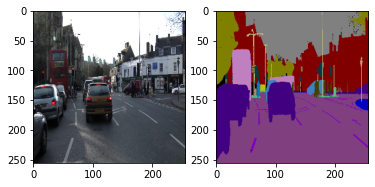

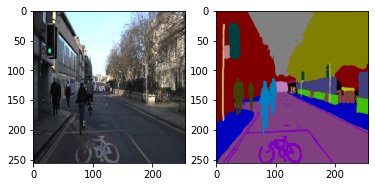

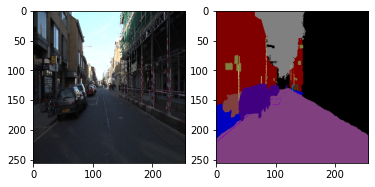

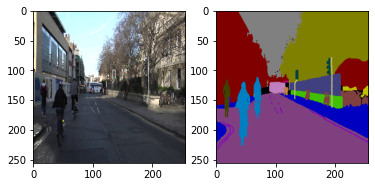

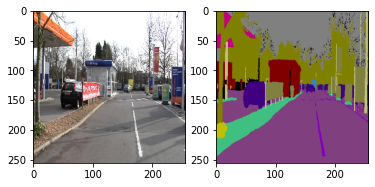

In [ ]:
# Make an iterator to extract images from the tensor dataset
test_frame_batches = tf.compat.v1.data.make_one_shot_iterator(test_frame_tensors) 
test_mask_batches = tf.compat.v1.data.make_one_shot_iterator(test_masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):  
  # Get the next image from iterator
  frame = test_frame_batches.next().numpy().astype(np.uint8)
  mask = test_mask_batches.next().numpy().astype(np.uint8)
    
  # Plot the corresponding frames (images) and masks
  fig = plt.figure()
  fig.add_subplot(1,2,1)
  plt.imshow(frame)
  fig.add_subplot(1,2,2)
  plt.imshow(mask)
  plt.show()

In [ ]:
val_data_frame = []
val_data_mask = []
for i in val_data:
  val_data_frame.append(i[0])
  val_data_mask.append(i[1])

val_frames_paths = [os.path.join(img_dir, fname) for fname in val_data_frame]
val_masks_paths = [os.path.join(mask_dir, fname) for fname in val_data_mask]

# Create dataset of tensors
val_frame_data = tf.data.Dataset.from_tensor_slices(val_frames_paths)
val_masks_data = tf.data.Dataset.from_tensor_slices(val_masks_paths)

# Read images into the tensor dataset
val_frame_tensors = val_frame_data.map(_read_to_tensor)
val_masks_tensors = val_masks_data.map(_read_to_tensor)

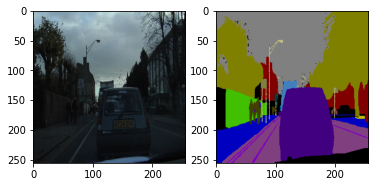

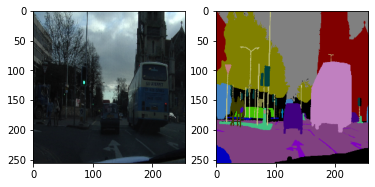

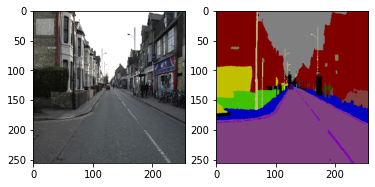

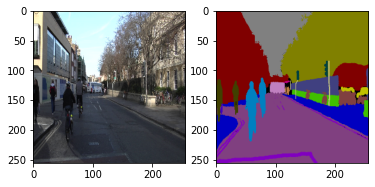

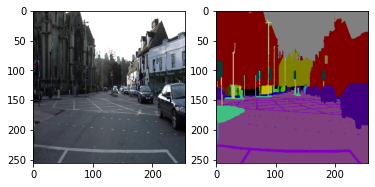

In [ ]:
# Make an iterator to extract images from the tensor dataset
val_frame_batches = tf.compat.v1.data.make_one_shot_iterator(val_frame_tensors) 
val_mask_batches = tf.compat.v1.data.make_one_shot_iterator(val_masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):  
  # Get the next image from iterator
  frame = val_frame_batches.next().numpy().astype(np.uint8)
  mask = val_mask_batches.next().numpy().astype(np.uint8)
    
  # Plot the corresponding frames (images) and masks
  fig = plt.figure()
  fig.add_subplot(1,2,1)
  plt.imshow(frame)
  fig.add_subplot(1,2,2)
  plt.imshow(mask)
  plt.show()

In [ ]:
train_data_frame = []
train_data_mask = []
for i in train_data:
  train_data_frame.append(i[0])
  train_data_mask.append(i[1])

train_frames_paths = [os.path.join(img_dir, fname) for fname in train_data_frame]
train_masks_paths = [os.path.join(mask_dir, fname) for fname in train_data_mask]

# Create dataset of tensors
train_frame_data = tf.data.Dataset.from_tensor_slices(train_frames_paths)
train_masks_data = tf.data.Dataset.from_tensor_slices(train_masks_paths)

# Read images into the tensor dataset
train_frame_tensors = train_frame_data.map(_read_to_tensor)
train_masks_tensors = train_masks_data.map(_read_to_tensor)

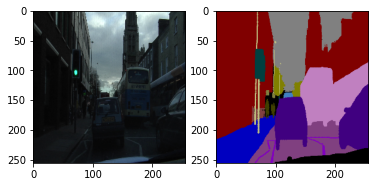

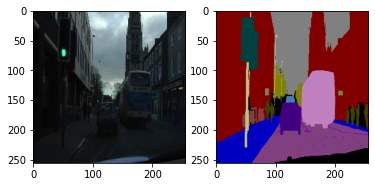

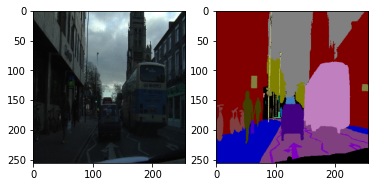

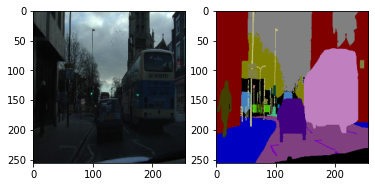

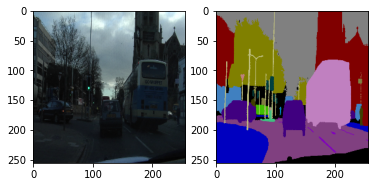

In [ ]:
# Make an iterator to extract images from the tensor dataset
train_frame_batches = tf.compat.v1.data.make_one_shot_iterator(train_frame_tensors) 
train_mask_batches = tf.compat.v1.data.make_one_shot_iterator(train_masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):  
  # Get the next image from iterator
  frame = train_frame_batches.next().numpy().astype(np.uint8)
  mask = train_mask_batches.next().numpy().astype(np.uint8)
    
  # Plot the corresponding frames (images) and masks
  fig = plt.figure()
  fig.add_subplot(1,2,1)
  plt.imshow(frame)
  fig.add_subplot(1,2,2)
  plt.imshow(mask)
  plt.show()

## Import matching between labels and RGB codes

In [ ]:
copyfile('gdrive/MyDrive/ProgettoDeepLearning/label_colors.txt', 'label_colors.txt') 

'label_colors.txt'

In [ ]:
label = pd.read_csv('label_colors.txt', header = None)

In [ ]:
lines = []
for elemento in label[0]:
  lines.append(elemento.strip().split("\t"))

In [ ]:
# Create code list and label list
code = []
names = []
for elemento in lines:
  if len(elemento) == 2:
    code.append(elemento[0])
    names.append(elemento[1])
  else:
    code.append(elemento[0])
    names.append(elemento[2])

In [ ]:
# Create a label dataframe
label_color = pd.DataFrame(names, columns = ['Names'])

In [ ]:
# Create a list of lists with [R, G, B] split codes 
class_map = []
for i in code: 
  R,G,B = i.split(' ')
  class_map.append(np.array([int(R), int(G), int(B)]))

In [ ]:
# Add RGB code column 
label_color['Code'] = class_map

In [ ]:
# Define a function that will be next used to pass from three colors channels to two (greyscale)
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [ ]:
ind = label_color.index.tolist()

## LinkNet

In [ ]:
# Class that generates data for Keras
class DataGenerator(Sequence):
    # Initialization
    def __init__(self, pair, class_map, batch_size=4, dim=(256,256,3), shuffle=True):
       
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    # Denotes the number of batches per epoch
    def __len__(self):
        
        return int(np.floor(len(self.pair) / self.batch_size))

    # Generate one batch of data
    def __getitem__(self, index):
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    # Updates indexes after each epoch
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # Generates data containing batch_size samples 
    # X : (n_samples, *dim, n_channels)
    def __data_generation(self, list_IDs_temp):
        
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [ ]:
# Generate data for training set 
train_generator = DataGenerator(train_data,label_color['Code'],batch_size=4, dim=(input_height,input_width,3), shuffle=True)
train_steps = train_generator.__len__()
train_steps

87

In [ ]:
# Example of dimentions of third batch 
X,y = train_generator.__getitem__(2)
y.shape

(4, 256, 256, 32)

In [ ]:
# Generate data for validation set
val_generator = DataGenerator(val_data, label_color['Code'], batch_size=4, dim=(input_height,input_width,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

43

## LinkNet definition

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
# Model architecture
model = Linknet(classes=32, input_shape = (256,256,3), activation='softmax', encoder_weights=None)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
# Define number of classes
n_classes = 32

# Define total loss as sum of dice and focal loss
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Compile keras model with defined optimizer, loss and metrics
sgd = tf.keras.optimizers.SGD(learning_rate=1E-2, momentum=0.9, nesterov=True)
model.compile(loss = total_loss, optimizer=sgd, metrics=['accuracy',sm.metrics.IOUScore(threshold = 0.6)])

In [ ]:
# Define callback parameters 
mc = ModelCheckpoint(mode='max', filepath='gdrive/MyDrive/ProgettoDeepLearning/Trained models/Trained_models_focal+dice/Checkpoint/LinkNet_FD_Check_NoWeights.h5', monitor='val_iou_score',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_iou_score', patience=5, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
rl = ReduceLROnPlateau(monitor='val_iou_score',factor=0.1,patience=5,verbose=1,mode="max",min_lr=0.0001)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')

In [ ]:
# Number of training images
train_count = len(train_df)

# Number of validation images
validation_count = len(val_df)

EPOCHS = 30
BATCH_SIZE = 4

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

# Train and validation model 
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps, epochs=EPOCHS, callbacks=[mc,es,tb,rl,cv])

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 1.0024 - accuracy: 0.1480 - iou_score: 0.2494
Epoch 1: val_iou_score improved from -inf to 0.29360, saving model to gdrive/MyDrive/ProgettoDeepLearning/Trained models/Trained_models_focal+dice/Checkpoint/LinkNet_FD_Check_NoWeights.h5
87/87 [==============================] - 72s 699ms/step - loss: 1.0024 - accuracy: 0.1480 - iou_score: 0.2494 - val_loss: 1.0066 - val_accuracy: 0.1641 - val_iou_score: 0.2936 - lr: 0.0100
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.4103 - iou_score: 0.3207
Epoch 2: val_iou_score improved from 0.29360 to 0.29534, saving model to gdrive/MyDrive/ProgettoDeepLearning/Trained models/Trained_models_focal+dice/Checkpoint/LinkNet_FD_Check_NoWeights.h5
87/87 [==============================] - 58s 662ms/step - loss: 0.9678 - accuracy: 0.4103 - iou_score: 0.3207 - val_loss: 0.9986 - val_accuracy: 0.1650 - val_iou_score: 0.2953 - lr: 0.0100
Epoch 3/30
87/8

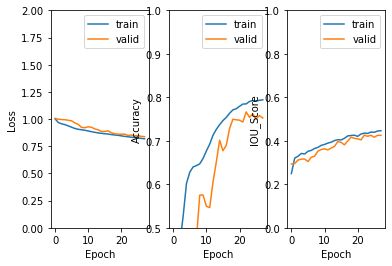

In [ ]:
# Plot the loss accuracy and IOU score in training and validation sets 
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.subplot(1, 3, 3)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('IOU_Score')
plt.legend(['train', 'valid'])

### Visualize image, associated mask and its predicted mask 

In [ ]:
# Randomly choose an image from the validation set
img_mask = random.choice(val_data)
img = img_to_array(load_img(img_mask[0] , target_size= (input_height, input_width)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (input_height, input_width)))

In [ ]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [ ]:
pred_label = make_prediction(model, img_mask[0], (input_height, input_width,3))
pred_label.shape

(256, 256)

In [ ]:
# Function that associate color to the predicted label
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [ ]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

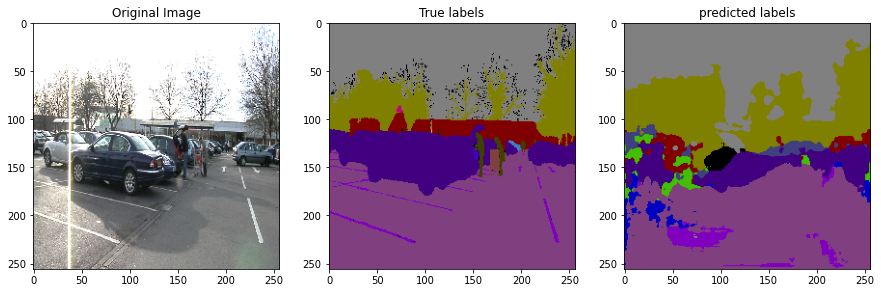

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

## Save the model

In [ ]:
model.save('gdrive/MyDrive/ProgettoDeepLearning/Trained models/Trained_models_focal+dice/LinkNet_FD_model_WithoutWeights.h5')